In [89]:
#importing libraries
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from sklearn.model_selection import cross_validate
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import pickle

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [90]:
#loading dataset
df1 = pd.read_csv('zomato_res_final.csv' , delimiter=',')
test_ds = pd.read_csv('test.csv' , delimiter=',')

In [91]:
df1.head(3)

,Name,Cost,Cuisine,Featured_in,Hours,Votes,Rating,Location,Type,View_menu,Book_table,Outlets,Delivery,Call
0,1947,950,2,1,"12noon – 3:15pm, 7pm – 10:15pm (Mon-Sun)",2209,4.1,Jayanagar,1,1,1,4,0,1
1,8293,300,3,,12noon – 10:30pm (Mon-Sun),79,4.1,KR Puram,,1,1,,0,1
2,8293,300,3,,12noon – 10:30pm (Mon-Sun),79,4.1,KR Puram,1,1,1,,0,1


In [92]:
#Data Pre-processing
#Since we scraped the data it is quite clean just removed the reastaurants with no rating(i.e New restaturants)
#Also removed restaurants with cost of two as zero
df1 = df1[df1.Rating != 0]
df1 = df1[df1.Cost != 0]
test_ds = test_ds[test_ds.Rating != 0]
test_ds = test_ds[test_ds.Cost != 0]

In [93]:
df1.head()

,Name,Cost,Cuisine,Featured_in,Hours,Votes,Rating,Location,Type,View_menu,Book_table,Outlets,Delivery,Call
0,1947,950,2,1,"12noon – 3:15pm, 7pm – 10:15pm (Mon-Sun)",2209,4.1,Jayanagar,1,1,1,4,0,1
1,8293,300,3,,12noon – 10:30pm (Mon-Sun),79,4.1,KR Puram,,1,1,,0,1
2,8293,300,3,,12noon – 10:30pm (Mon-Sun),79,4.1,KR Puram,1,1,1,,0,1
3,@ Biryani Central,500,4,,"12noon – 3:30pm, 7pm – 1am (Mon-Thu),12noon –...",128,2.6,Marathahalli,1,1,1,,0,1
4,@99,200,4,,"11:30am – 3pm, 6:30pm – 11:30pm (Mon-Sun)",37,3.4,Whitefield,1,1,0,,0,1


In [94]:
df1.shape 

(5167, 14)

In [95]:
#Conversion of data types to float and int
def preprocessing(df1):
    df1['Rating'] = pd.to_numeric(df1['Rating'], errors='coerce')
    df1['Featured_in'] = pd.to_numeric(df1['Featured_in'], errors='coerce')
    df1['Votes'] = pd.to_numeric(df1['Votes'], errors='coerce')
    df1['Type'] = pd.to_numeric(df1['Type'], errors='coerce')
    df1['Outlets'] = pd.to_numeric(df1['Outlets'], errors='coerce')
    df1['Cost'] = pd.to_numeric(df1['Cost'], errors='coerce')
    return df1
df1 = preprocessing(df1)
test_ds = preprocessing(test_ds)
df1.dtypes

Name            object
Cost           float64
Cuisine          int64
Featured_in    float64
Hours           object
Votes            int64
Rating         float64
Location        object
Type           float64
View_menu        int64
Book_table       int64
Outlets        float64
Delivery         int64
Call             int64
dtype: object

In [96]:
#Features that will be used for model training
features = ["Cost" , "Cuisine" ,"Featured_in", "Votes" , "Type" , "Book_table" , "Outlets" , "Delivery" , "Call" , "View_menu"]


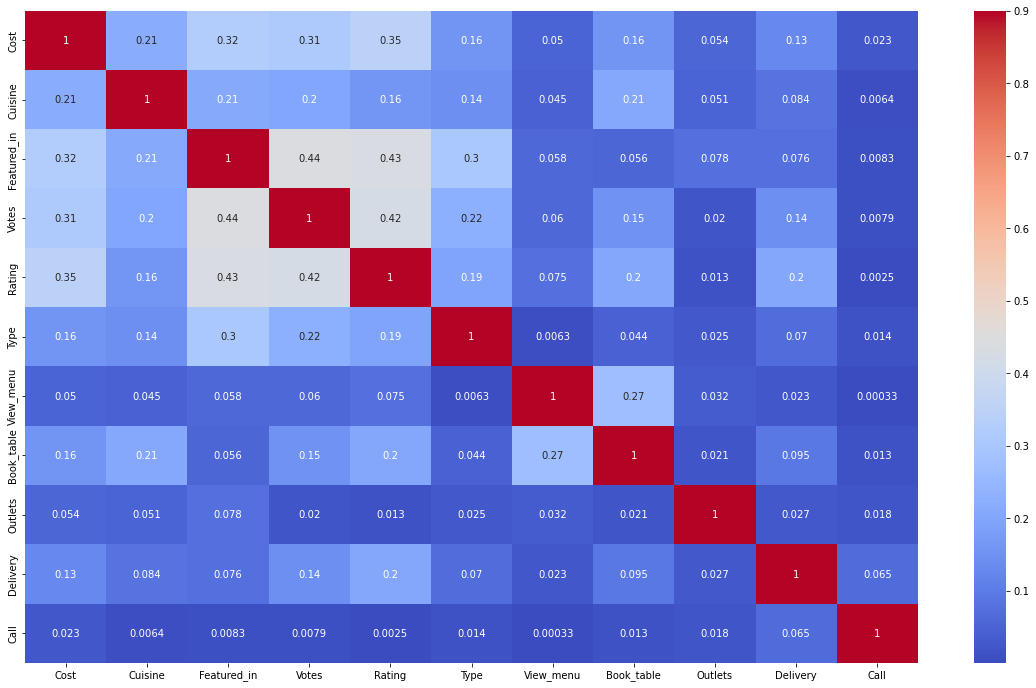

In [97]:
#Correlation matrix with heatmap
corr_matrix = df1.corr()
f, ax1 = plt.subplots(figsize=(20,12)) 
ax1=sns.heatmap(abs(corr_matrix),annot=True,cmap='coolwarm',vmax = 0.9);

<AxesSubplot:xlabel='Rating', ylabel='count'>

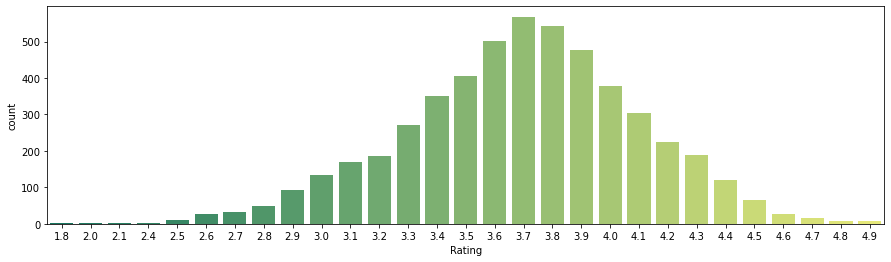

In [98]:
#Set the width and height of the figure
plt.figure(figsize=(15,4))
#Plotting countplot to check the variation in demand wrt months of the year.
sns.countplot(df1['Rating'], data= df1, palette= 'summer')

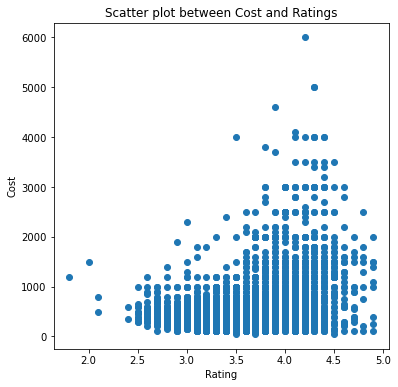

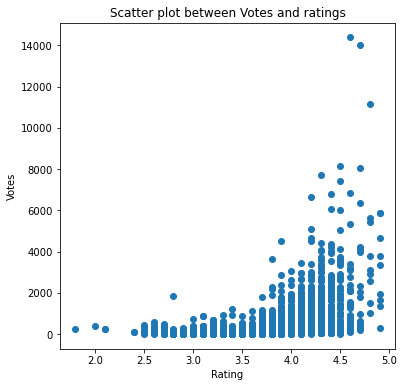

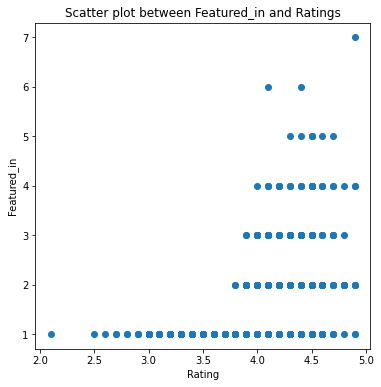

Text(0, 0.5, 'Total extra outlets')

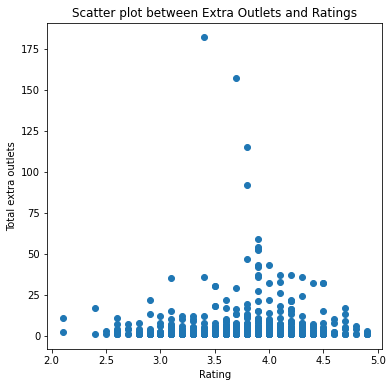

In [99]:
#Plotting scatter plots between various features to check their dependency.

plt.rcParams['figure.figsize']=(6,6)
plt.scatter(df1['Rating'], df1['Cost'])
plt.title('Scatter plot between Cost and Ratings')
plt.xlabel('Rating')
plt.ylabel('Cost')
plt.show()
plt.scatter(df1['Rating'], df1['Votes'])
plt.title('Scatter plot between Votes and ratings')
plt.xlabel('Rating')
plt.ylabel('Votes')
plt.show()
plt.scatter(df1['Rating'], df1['Featured_in'])
plt.title('Scatter plot between Featured_in and Ratings')
plt.xlabel('Rating')
plt.ylabel('Featured_in')
plt.show()
plt.scatter(df1['Rating'], df1['Outlets'])
plt.title('Scatter plot between Extra Outlets and Ratings')
plt.xlabel('Rating')
plt.ylabel('Total extra outlets')

In [100]:
#Replaced Nan values with 0
df1.fillna(0, inplace=True)
train, test = train_test_split(df1, test_size=0.3 , random_state = 5)
test_label = test["Rating"]


In [101]:
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 0,
          "seed": 42
          }


In [102]:
#Evaluation metrics for xgboost
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

In [103]:
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe
def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [104]:
num_trees = 100
print("Train a XGBoost model")
val_size = 100000
X_train, X_test = train_test_split(df1, test_size=0.01)
dtrain = xgb.DMatrix(X_train[features], X_train["Rating"])
dvalid = xgb.DMatrix(X_test[features], X_test["Rating"])
dtest = xgb.DMatrix(test[features])
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain)
filename="submission.sav"
pickle.dump(gbm, open(filename,"wb"))

Train a XGBoost model
[00:45:54] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




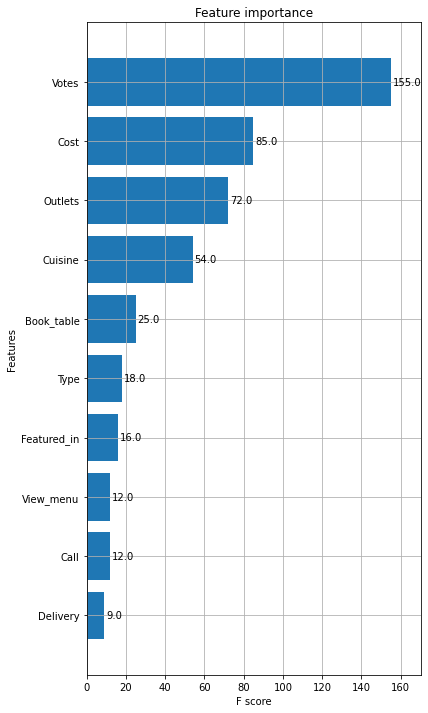

In [105]:
fig, ax = plt.subplots(figsize=(6,12))
xgb.plot_importance(gbm, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [106]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
error = rmspe(train_probs, X_test['Rating'].values)
print('Accuracy', (1-error)*100)

print("Predicting")
train_probs = gbm.predict(xgb.DMatrix(test_ds[features]))
error = rmspe(train_probs, test_ds['Rating'].values)
print ('Accuracy' , (1 - error)*100)
test_probs = gbm.predict(xgb.DMatrix(test_ds[features]))
submission = pd.DataFrame({"Name": test_ds["Name"], "Rating": test_probs})
submission.to_csv("test_submission.csv", index=False)

Validating
Accuracy 92.3690134945246
Predicting
Accuracy 91.73947644016313
